In [1]:
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

# I. SQL

Имеются данные по времени совершения сетевых действий (cчитаем, что записей миллиарды)

ID - идентификатор абонента
BS - номер базовой станции (вышки)
time - время совершения разового действия (отправка смс)

Необходимо построить таблицу вида

ID	BS	time_start	time_end

, где по каждому абоненту будет приведено время начала его присутствия на БС и время окончания			

Условно считаем, что время начала совпадает со временем первого действия на этой БС, 			
а время окончания - со временем первого действия на следующей БС, либо, если ее нет, со временем последнего действия на этой БС

In [2]:
import sqlite3
import pandas as pd

In [3]:
# Путь к тестовой БД sqlite3 с предварительно сгенерированными (https://www.mockaroo.com/)
# случайными данными согласно образцу в задании:

db_file = '../resources/mts_test.db'

In [4]:
def create_connection(db_file):
    """Создает полключение к базе данных sqlite3"""
    try:
        conn = \
            sqlite3.connect(db_file,
                            detect_types=sqlite3.PARSE_DECLTYPES |
                            sqlite3.PARSE_COLNAMES)
        return conn
    except Error as e:
        print(e)

In [5]:
# Проверяем соединение:

create_connection(db_file)

In [8]:
def bs_user_action_selection(db_file, limit=10):
    conn = create_connection(db_file, )
    with conn:
        cursor = conn.cursor()
        sql = \
            '''SELECT * FROM bs_user_action LIMIT {}'''.format(limit)
        query = cursor.execute(sql)
        cols = [column[0] for column in query.description]
        result = pd.DataFrame(query.fetchall(), columns=cols)
        return result

In [9]:
# Исходная таблица с предварительно сгенерированными случайными данными:
bs_user_action_selection(db_file)

,ID,BS,time
0,1009,5,10:22:18
1,1009,3,06:21:51
2,1010,2,17:06:36
3,1009,3,20:43:09
4,1004,4,03:48:42
5,1002,3,20:43:43
6,1002,2,09:15:37
7,1006,2,07:45:29
8,1005,2,04:27:36
9,1006,5,13:25:35


In [10]:
# Создадим индекс на ID и time - для более оптимального и упорядоченного хранения пар ID и time,
# которыми будем оперировать далее.

conn = create_connection(db_file, )
cursor = conn.cursor()
sql = '''
    CREATE INDEX IF NOT EXISTS ID_time ON bs_user_action (ID, time);
'''
cursor.execute(sql)
conn.close()

In [11]:
def result_table(db_file,):
    conn = create_connection(db_file, )
    with conn:
        cursor = conn.cursor()
        sql = \
            '''
            WITH action_numbers AS (
            SELECT
                ID,
                BS,
                time,
                -- Проставляем каждому действию конкретного абонента порядковый номер:
                row_number() OVER (PARTITION BY ID ORDER BY time ASC) AS action_number 
            FROM bs_user_action
            ORDER BY ID, time
            ),
            joins AS (
            SELECT
                an_first.ID, 
                an_first.BS AS current_BS, an_first.time AS time_start, an_first.action_number AS current_action,
                an_second.BS AS end_BS, an_second.time AS time_end, an_second.action_number AS next_action
            FROM action_numbers AS an_first
            -- Делаем левое соединение таблиц с пользовательскими действиями
            -- (чтобы не потерять случаи с последним пользовательским действием) 
            -- по ID абонента и его следующему действию. 
            LEFT JOIN action_numbers AS an_second ON an_first.ID = an_second.ID 
                AND an_first.action_number = an_second.action_number - 1
            ORDER BY an_first.time)
            -- Таблица с результатами:
            SELECT
                ID,
                current_BS AS BS,
                time_start,
                -- Не забываем включить условие, что если отсутствует следующее действие aбонента на следующей БС,
                -- то в качестве end_time проставляем время действия на текущей БС:
                CASE WHEN end_BS IS NULL THEN time_start ELSE time_end END AS time_end
            FROM joins
            ORDER BY ID, time_start;
            '''
        query = cursor.execute(sql)
        cols = [column[0] for column in query.description]
        result = pd.DataFrame(query.fetchall(), columns=cols)
        return result

In [12]:
%%timeit
result_table(db_file)

10.8 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
df = result_table(db_file)

In [14]:
# Проверим результат на одном из абонентов:
df[df.ID == 1010]

,ID,BS,time_start,time_end
917,1010,5,00:33:24,00:38:31
918,1010,1,00:38:31,00:46:42
919,1010,5,00:46:42,01:07:15
920,1010,1,01:07:15,01:30:55
921,1010,5,01:30:55,01:41:28
...,...,...,...,...
995,1010,3,23:14:33,23:23:30
996,1010,4,23:23:30,23:32:14
997,1010,3,23:32:14,23:56:40
998,1010,4,23:56:40,23:57:49


# II. Python

1. Есть два списка чисел: цены товаров в одном салоне и цены товаров в другом салоне.
Нужно сравнить средние цены, минимальные цены и максимальные в салонах. Если первое зачение меньше надо вернуть 'First', если второе, то 'Second', а если равны, то 'Equal'
Например, для func_name([1, 2, 3], [2, 2, 2]) должно вернуться ('Equal', 'First', 'Second')
, где 1 - средняя цена в первом салоне, 2 - минимальная цена в первом салоне, 3 - максимальная цена в первом салоне; во втором салоне все цены равны 2

(доп. усложение: код следует написать после слова "return", а не между определением функции и "return", как обычно)

In [15]:
def mean_min_max_compare(x, y):
    """
    Маппирует лямбда функцию сравнения попарно к двум спискам, возвращает ответ в виде кортежа.
    """
    return tuple(map(lambda x, y: 'First' if x < y else 'Second' if x > y else 'Equal', x, y))

In [16]:
mean_min_max_compare([1, 2, 3], [2, 2, 2])

('First', 'Equal', 'Second')

2. Напишите функцию, которая по множеству, возвращает список всех его подмножеств
проверяться будет на данных вида set(range(10)), более сложные/составные типы данных можно не учитывать

In [17]:
from itertools import chain, combinations

def powerset(x):
    """
    Подмножества (вкл. пустое множество) с помощью инструментов стандартной библиотеки itertools:
    combinations (кобинации без повторений) и chain.from_iterable - "сцепка" элементов итерируемых объектов.
    """
    s = list(x)
    return chain.from_iterable(combinations(s, r) for r in range(len(x)+1))

In [18]:
list(powerset(set(range(3))))

[(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]

In [19]:
list(powerset({'A', 'B', 'C', 'D'}))

[(),
 ('A',),
 ('D',),
 ('B',),
 ('C',),
 ('A', 'D'),
 ('A', 'B'),
 ('A', 'C'),
 ('D', 'B'),
 ('D', 'C'),
 ('B', 'C'),
 ('A', 'D', 'B'),
 ('A', 'D', 'C'),
 ('A', 'B', 'C'),
 ('D', 'B', 'C'),
 ('A', 'D', 'B', 'C')]

3. Загрузите набор данных "Breast Cancer Wisconsin (Diagnostic) Database" 
(с помощью библиотеки sklearn; метод load_breast_cancer())

Каково соотношение классов?
Насколько сильно различаются между собой объекты классов Malignan и Benign по паре признаков 'mean radius' и 'mean texture', а также по паре признаков 'mean perimeter' и 'mean area'?
(необходимо изобразить графически)

Какие фичи в наборе данных можно считать наиболее важными для машинного разделения на классы Malignan и Benign? Какими можно пренебречь?

In [20]:
from sklearn.datasets import load_breast_cancer
import numpy as np

In [21]:
# Преобразуем датасет в pandas dataframe:

cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))

In [22]:
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0


In [23]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [24]:
df['target_names'] = df['target'].apply(lambda x: 'malignant' if x == 0 else 'benign')

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='mean radius', ylabel='mean texture'>

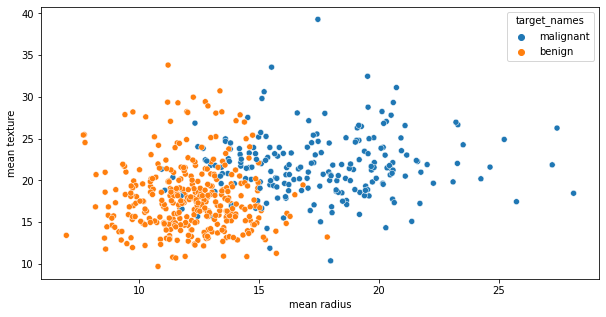

In [26]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df, x="mean radius", y="mean texture", hue="target_names")

# Видим хорошее разделение наборов по mean radius ~= 15, корреляции между фичами нет

<AxesSubplot:xlabel='mean perimeter', ylabel='mean area'>

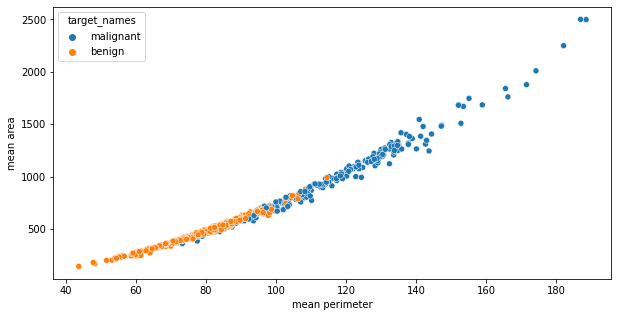

In [27]:
plt.figure(figsize = (10,5))
sns.scatterplot(data=df, x="mean perimeter", y="mean area", hue="target_names")

# Видим очень сильную корреляцию mean area и mean perimeter
# Наборы отлично разделяются

<AxesSubplot:>

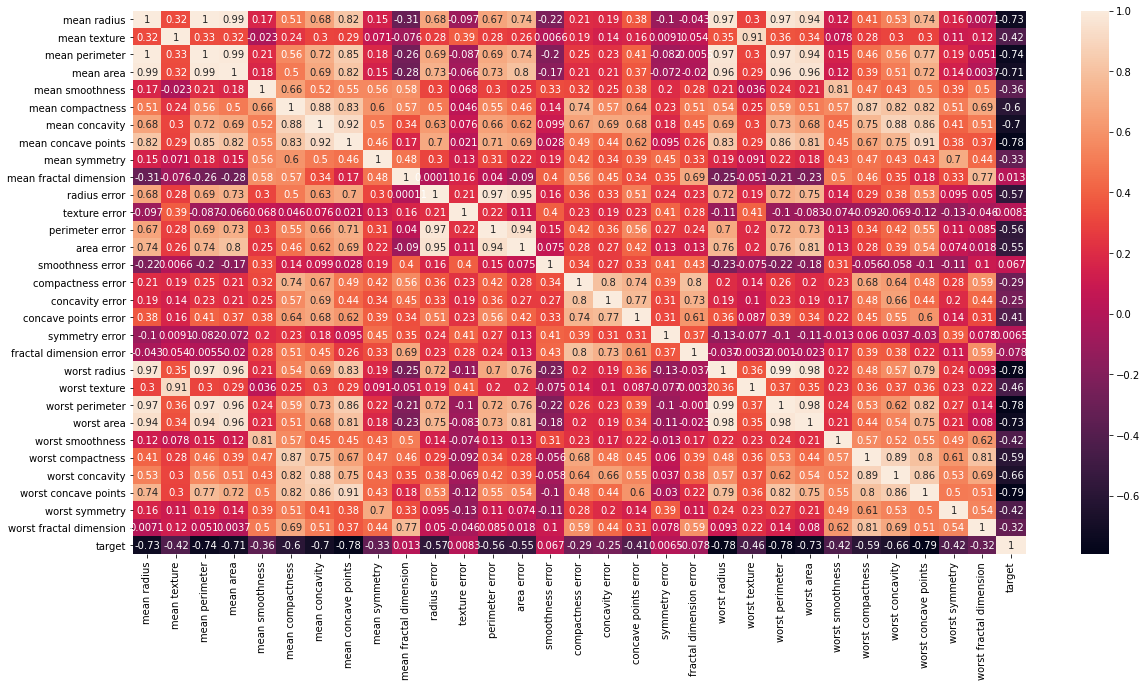

In [28]:
corrMatrix = df.corr()
plt.figure(figsize = (20,10))
sns.heatmap(corrMatrix, annot=True)
# Видим фичи с высокой корреляцией, к примеру mean_radius - mean_area - одним из элементов можно пренебречь
# Фичи с низкой корреляцией целесообразно оставить для дальнейшего анализа